# Testing Image Preprocessing Pipeline

In [1]:
from image_preprocessing import NormalizeImageChannels, ZScoreNorm, BackgroundSubtraction, FlatFieldCorrection, SelectActiveChannel, TileImages, SplitZImageStack, PreprocessImage
from image_preprocessing import OldFlatFieldCorrection
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Zhao Lab - Preprocessing Pipeline
Using default parameters

* Output image scale is between 0 and 52428

(2304, 2304, 3)


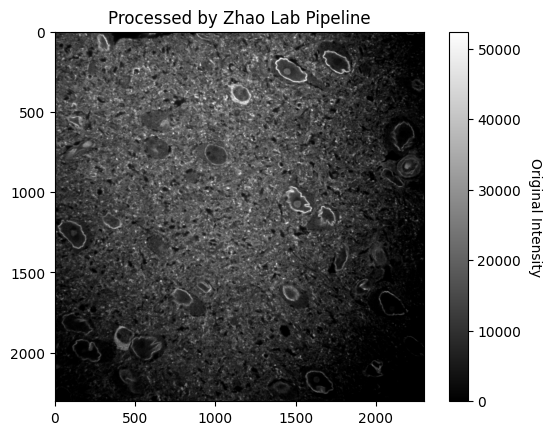

In [3]:
im2 = tiff.imread("./images/optimized_with_zhaolab_pipeline/2_RGB_Cy5 W1_optimized.ome.tif")

im2 = np.moveaxis(im2, 0, -1)
print(im2.shape)

im2_act, _ = SelectActiveChannel(im2)

im_plt = plt.imshow(im2_act, cmap="gray")
cbar0 = plt.colorbar(im_plt)
cbar0.set_label("Original Intensity", rotation=270, labelpad=15)
plt.title("Processed by Zhao Lab Pipeline")
plt.show()

In [4]:
print(im2.max(), im2.min())

52428 0


## Test Custom Preprocessing Functions


In [2]:
img = tiff.imread("./images/test_images/2_RGB_coomassie.tif")
print(img.shape)
print(img.ndim)
print(img.dtype)

(2304, 2304, 3)
3
uint8


Select active color channel, dims as (h, w, 1)

(3, 2304, 2304)
(1, 2304, 2304)


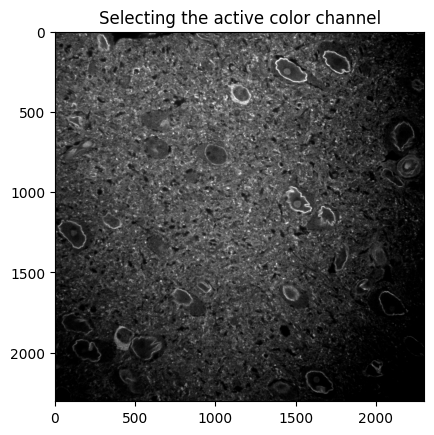

In [3]:
active_ch, _ = SelectActiveChannel(img)
print(active_ch.shape)
plt.imshow(active_ch[0, :, :,], cmap='gray')
plt.title("Selecting the active color channel")
plt.show()

Background subtraction

In [4]:
active_ch.shape

(1, 2304, 2304)


=== Background Subtraction Analysis ===

Channel 0:
  Background value (percentile): 0.00
  Original - Min: 0.00, Max: 255.00, Mean: 55.15
  Corrected - Min: 0.00, Max: 255.00, Mean: 55.15
  Mean shift: 0.00 (0.00%)
  Background as % of max: 0.00%


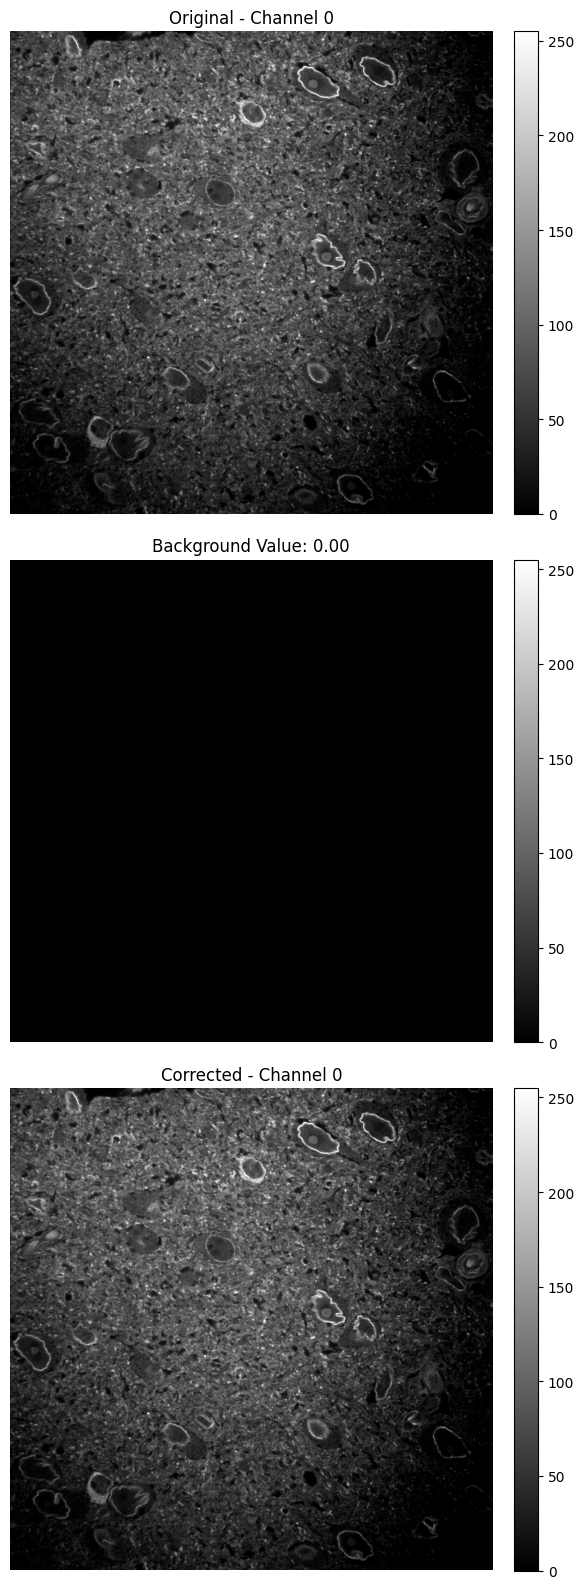

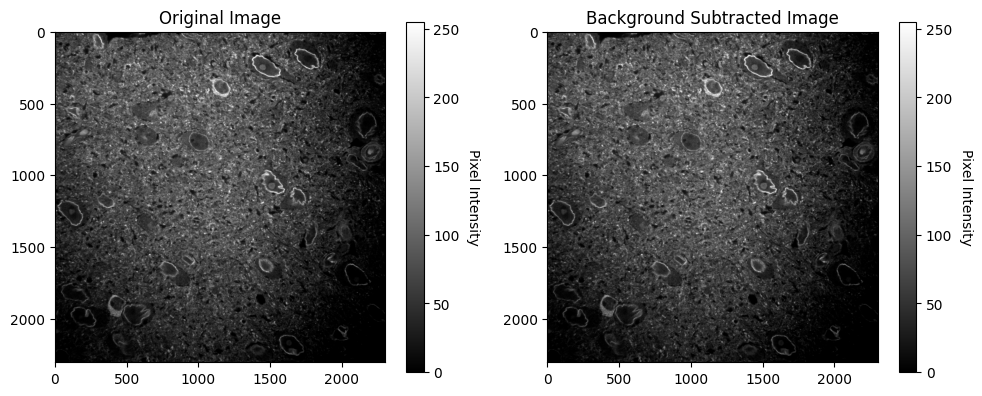

In [5]:
# test background subtraction
bg_subbed = BackgroundSubtraction(active_ch, plot = True)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Left: Original image ---
im0 = axes[0].imshow(active_ch[0, :, :,], cmap='gray')
axes[0].set_title("Original Image")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Pixel Intensity", rotation=270, labelpad=15)

# --- Right: Processed image ---
im1 = axes[1].imshow(bg_subbed[0, :, :], cmap='gray')
axes[1].set_title("Background Subtracted Image")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Pixel Intensity", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

Test FlatField correction

Channel 0: Corrected (range=163.00, max_boost=3.00x)


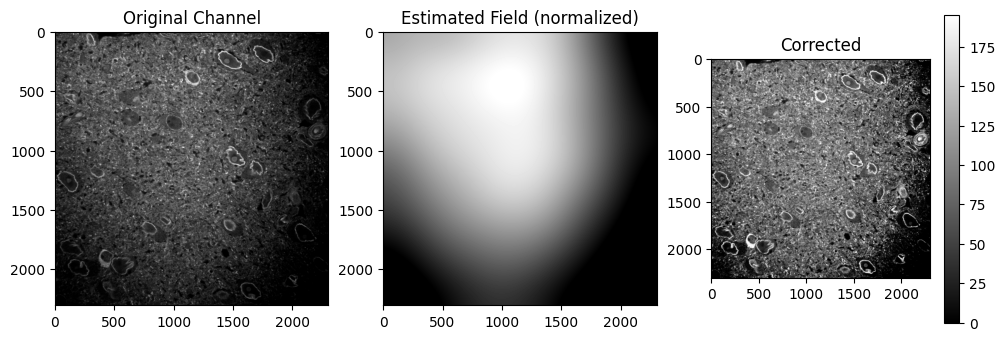

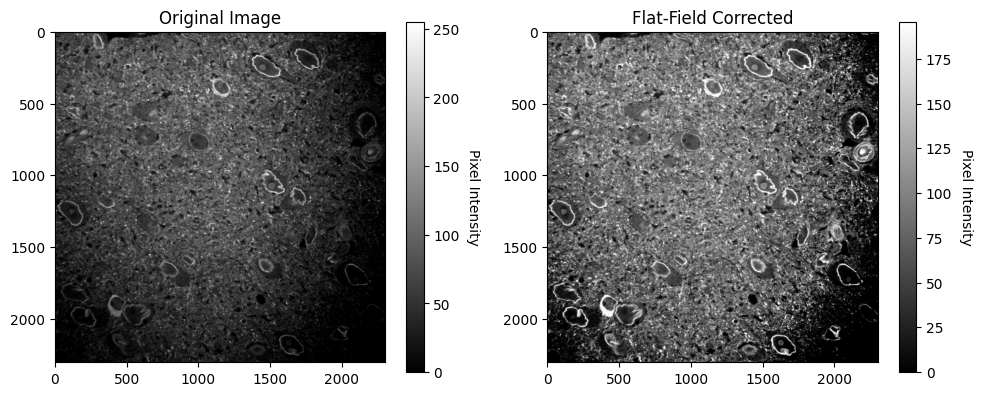

In [6]:
# test flat-field
ff_corr = FlatFieldCorrection(bg_subbed, plot=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Left: Original image ---
im0 = axes[0].imshow(bg_subbed[0, :, :,], cmap='gray')
axes[0].set_title("Original Image")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Pixel Intensity", rotation=270, labelpad=15)

# --- Right: Processed image ---
im1 = axes[1].imshow(ff_corr[0, :, :,], cmap='gray')
axes[1].set_title("Flat-Field Corrected")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Pixel Intensity", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

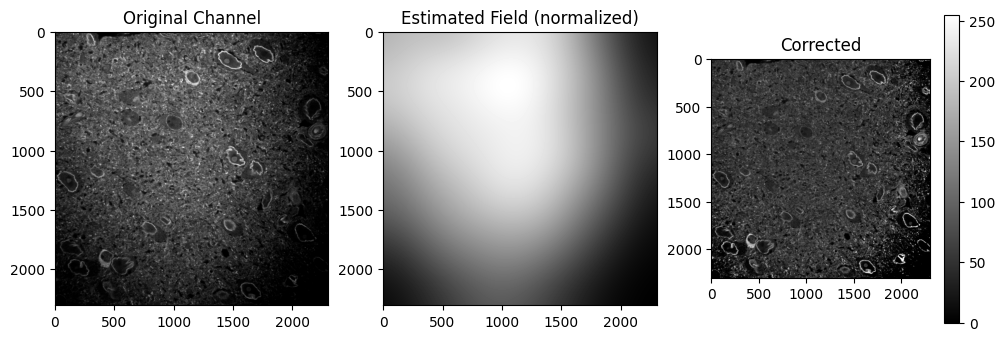

In [7]:
# look at older method
ff_corr_older = OldFlatFieldCorrection(bg_subbed, plot=True)

In [8]:
print(ff_corr.min())
print(ff_corr.max())

0.0
195.6


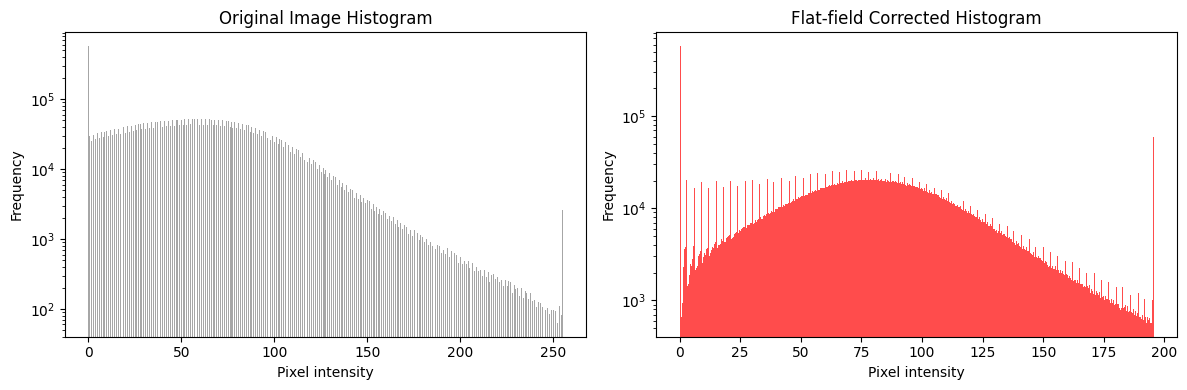

In [9]:
bins = 500

plt.figure(figsize=(12, 4))

# Original histogram
plt.subplot(1, 2, 1)
plt.hist(bg_subbed.ravel(), bins=bins, color='gray', alpha=0.7, log=True)
plt.title("Original Image Histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

# Flat-field corrected histogram
plt.subplot(1, 2, 2)
plt.hist(ff_corr.ravel(), bins=bins, color='red', alpha=0.7, log=True)
plt.title("Flat-field Corrected Histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

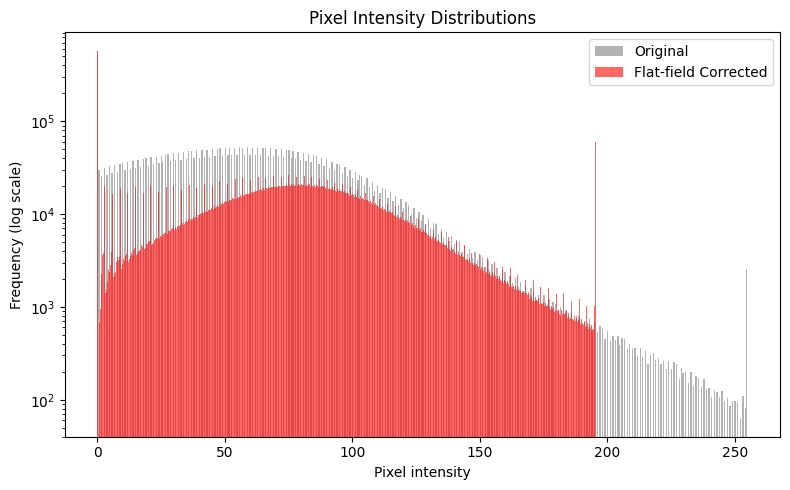

In [10]:
bins = 500

plt.figure(figsize=(8, 5))

# Plot both histograms together
plt.hist(bg_subbed.ravel(), bins=bins, color='gray', alpha=0.6, log=True, label='Original')
plt.hist(ff_corr.ravel(), bins=bins, color='red', alpha=0.6, log=True, label='Flat-field Corrected')

plt.title("Pixel Intensity Distributions")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.tight_layout()
plt.show()


Check image tiling
Note: Not using this function, using the tile functionality within the PyTorch dataloader

In [11]:
# check tiling function
tiles = TileImages(active_ch)

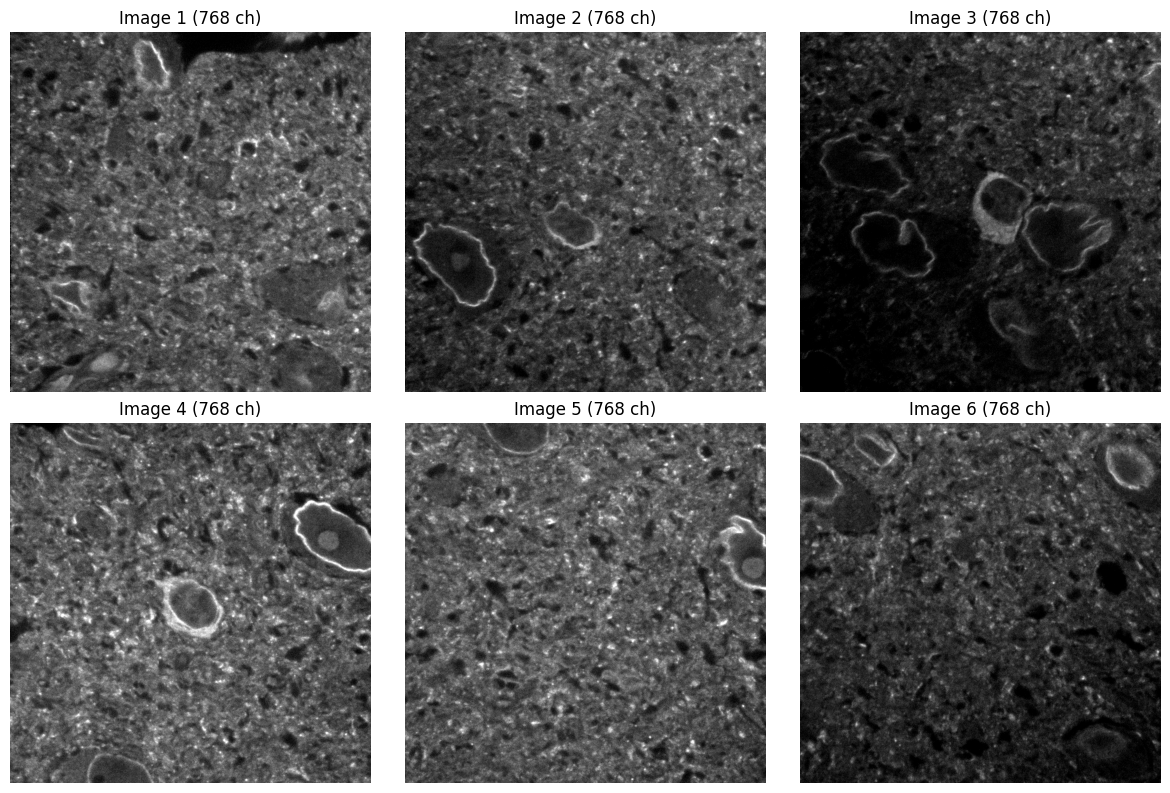

In [12]:
# plot the first 6 tiled images if 6
num_plots = len(tiles)

# plot the tiles
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, (img, ax) in enumerate(zip(tiles, axes)):
    h, w, n = img.shape

    # Create RGB composite
    ax.imshow(tiles[i][0, :, :,], cmap="gray")
    ax.set_title(f"Image {i+1} ({n} ch)")
    ax.axis("off")

# hide any unused subplots if list < 6
for j in range(num_plots, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

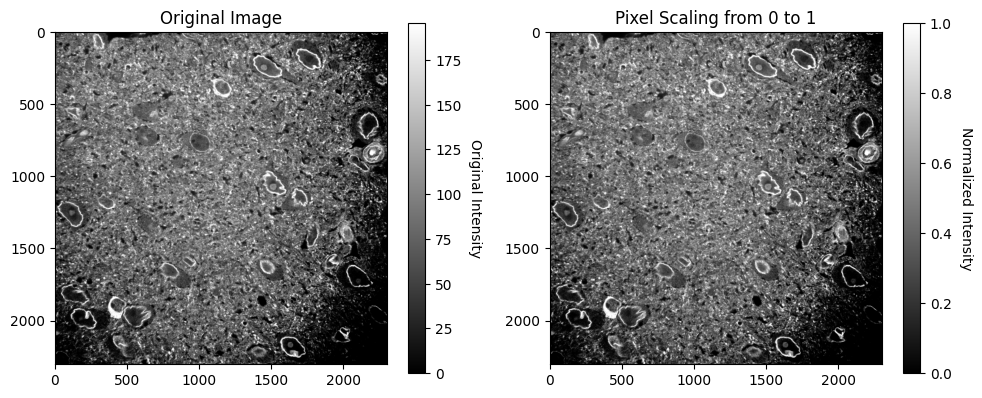

In [13]:
# test image normalization
zsc = ZScoreNorm(ff_corr)
norm_img = NormalizeImageChannels(zsc)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Left: Original image ---
im0 = axes[0].imshow(ff_corr[0, :, :,], cmap='gray')
axes[0].set_title("Original Image")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Original Intensity", rotation=270, labelpad=15)

# --- Right: Normalized image ---
im1 = axes[1].imshow(norm_img[0, :, :,], cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Pixel Scaling from 0 to 1")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Normalized Intensity", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## Test Z-Stack Splitting

In [13]:
z_stck_path = "images"
SplitZImageStack(z_stck_path)

Found 1 .nd2 file(s)
Output directory: images/processed_zstack

Processing: 60x_z001.nd2
  Image shape: (118, 4, 2304, 2304)
  Found 118 slice(s)
  Saved 10/118 slices
  Saved 20/118 slices
  Saved 30/118 slices
  Saved 40/118 slices
  Saved 50/118 slices
  Saved 60/118 slices
  Saved 70/118 slices
  Saved 80/118 slices
  Saved 90/118 slices
  Saved 100/118 slices
  Saved 110/118 slices
  Saved 118/118 slices

Processing complete! Saved images


## Test full preprocessing pipeline
Using a sample z-stack (60x_z001.nd2), not final dataset

(4, 2304, 2304)


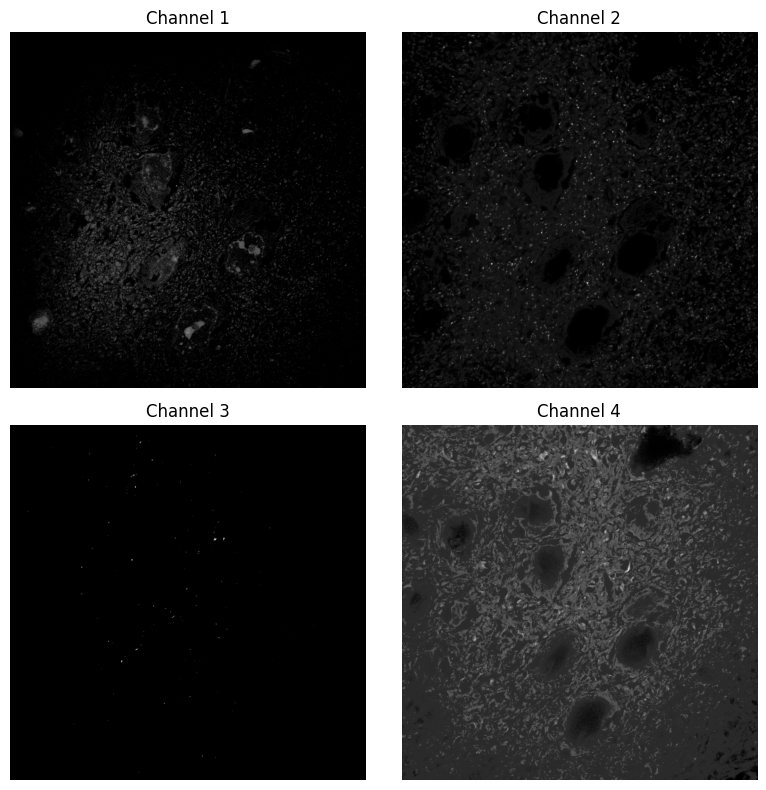

In [14]:
# load tif and view
tif_path = "images/processed_zstack/60x_z001_60.tif"
im = Image.open(tif_path)
im_array = np.array(im)
im_array = np.moveaxis(im_array, -1, 0)
print(im_array.shape)

# look at one of the tif files - verify if saved right
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()  # Flatten to easily iterate

# Plot each channel
for i in range(4):
    ax = axes[i]
    ax.imshow(im_array[i, :, :], cmap='gray')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

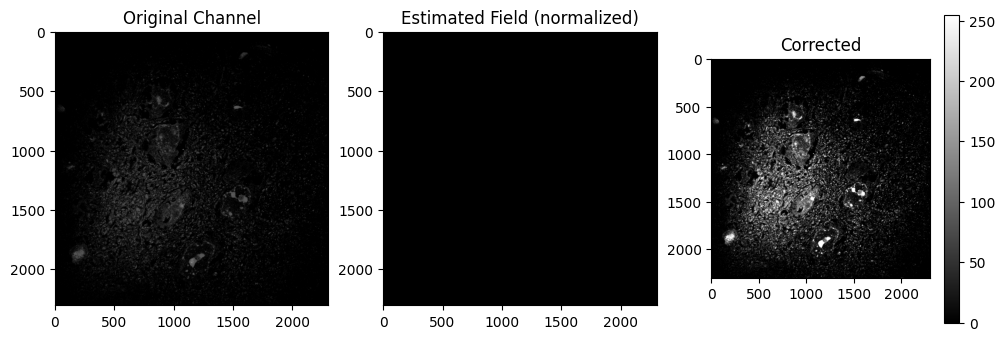

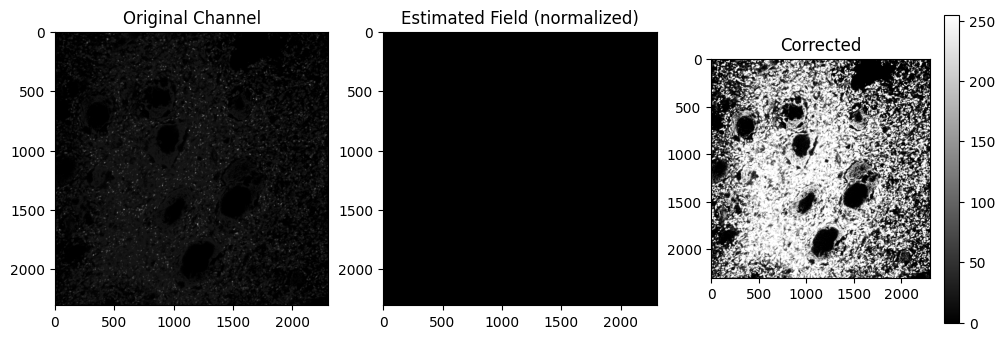

Channel 2: Skipped (range=0.00, mean=0.00)


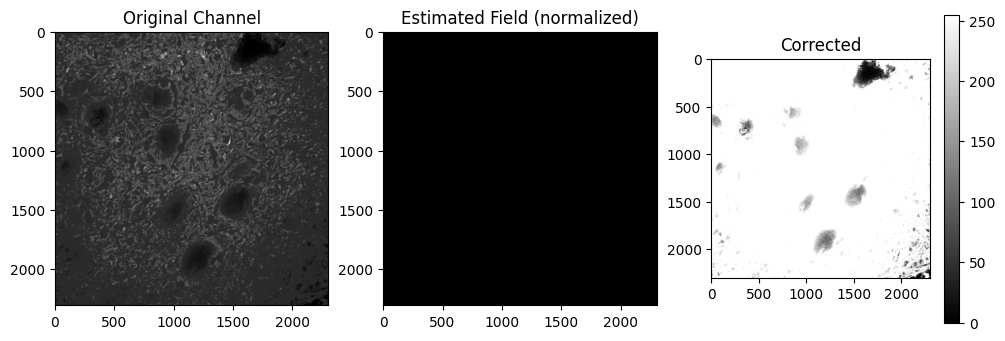

In [15]:
img = OldFlatFieldCorrection(im_array, plot=True)

(4, 2304, 2304)

=== Background Subtraction Analysis ===

Channel 0:
  Background value (percentile): 0.00
  Original - Min: 0.00, Max: 3.00, Mean: 0.09
  Corrected - Min: 0.00, Max: 3.00, Mean: 0.09
  Mean shift: 0.00 (0.00%)
  Background as % of max: 0.00%

Channel 1:
  Background value (percentile): 0.00
  Original - Min: 0.00, Max: 12.00, Mean: 0.60
  Corrected - Min: 0.00, Max: 12.00, Mean: 0.60
  Mean shift: 0.00 (0.00%)
  Background as % of max: 0.00%

Channel 2:
  Background value (percentile): 0.00
  Original - Min: 0.00, Max: 1.00, Mean: 0.00
  Corrected - Min: 0.00, Max: 1.00, Mean: 0.00
  Mean shift: 0.00 (0.00%)
  Background as % of max: 0.00%

Channel 3:
  Background value (percentile): 0.00
  Original - Min: 0.00, Max: 6.00, Mean: 1.24
  Corrected - Min: 0.00, Max: 6.00, Mean: 1.24
  Mean shift: 0.00 (0.00%)
  Background as % of max: 0.00%


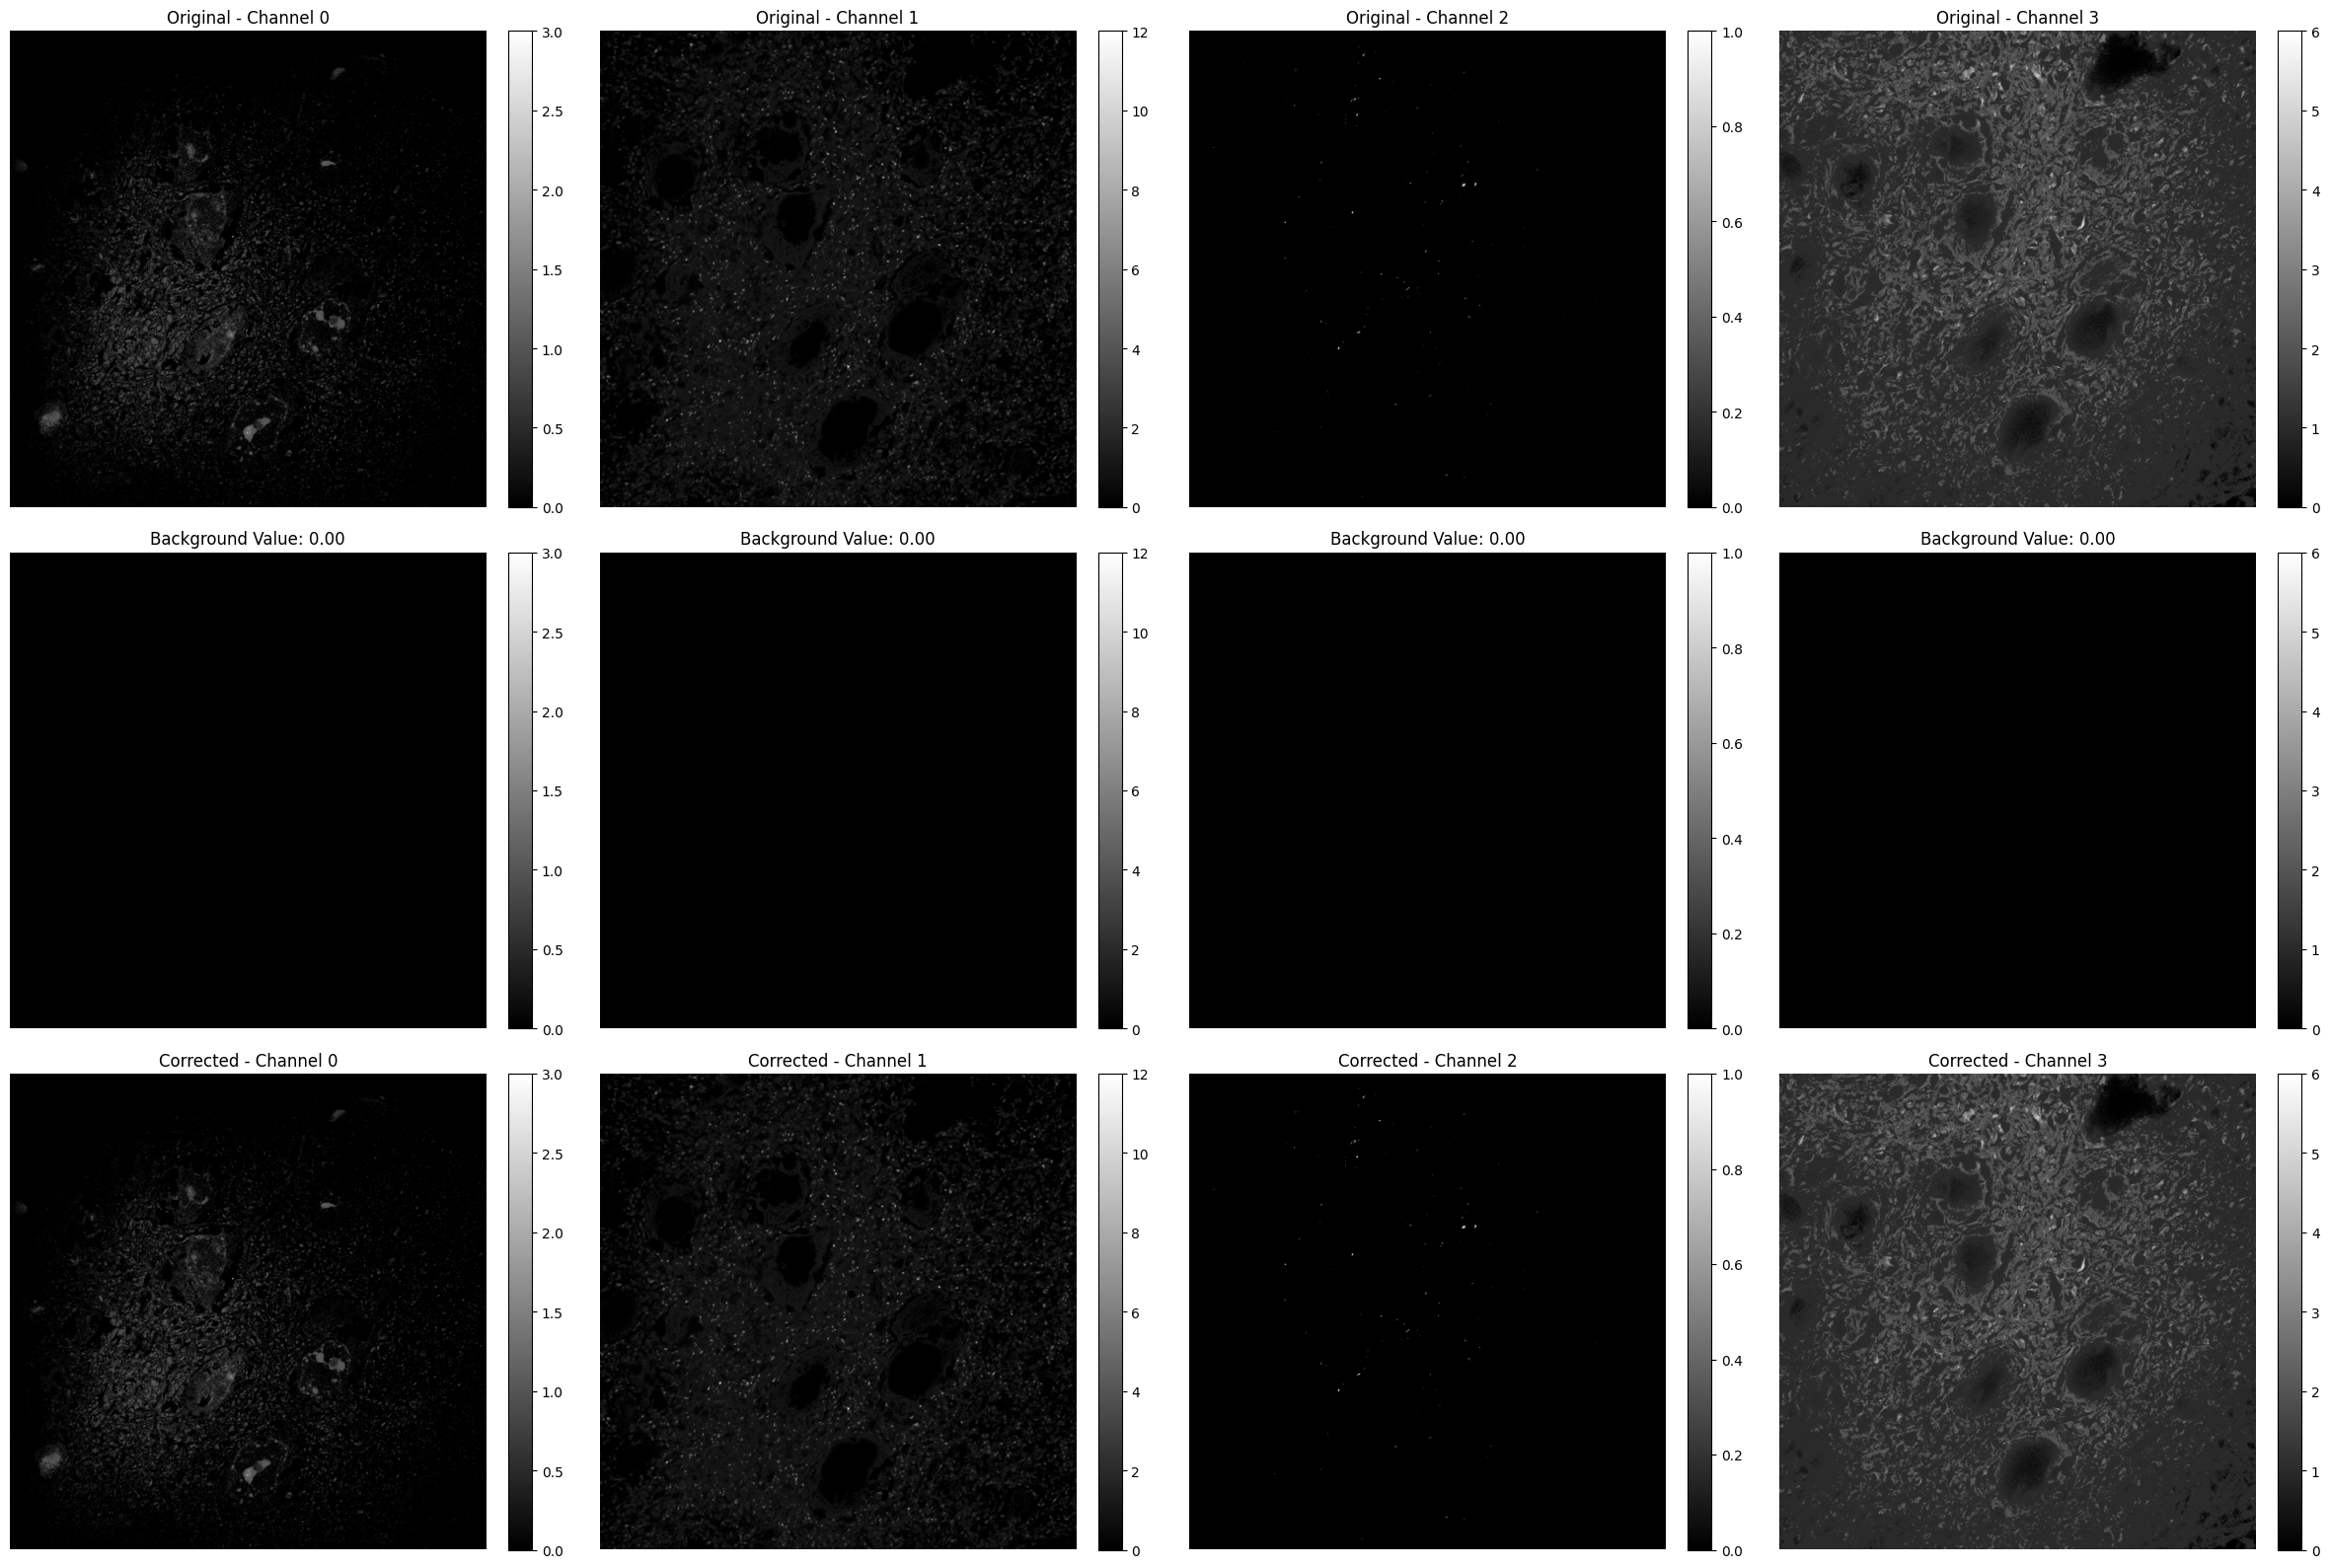

Channel 0: Corrected (range=1.00, max_boost=3.00x)


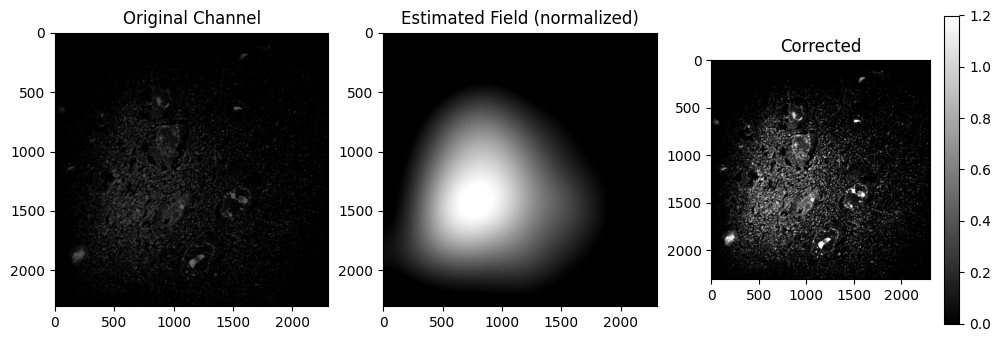

Channel 1: Corrected (range=3.00, max_boost=3.00x)


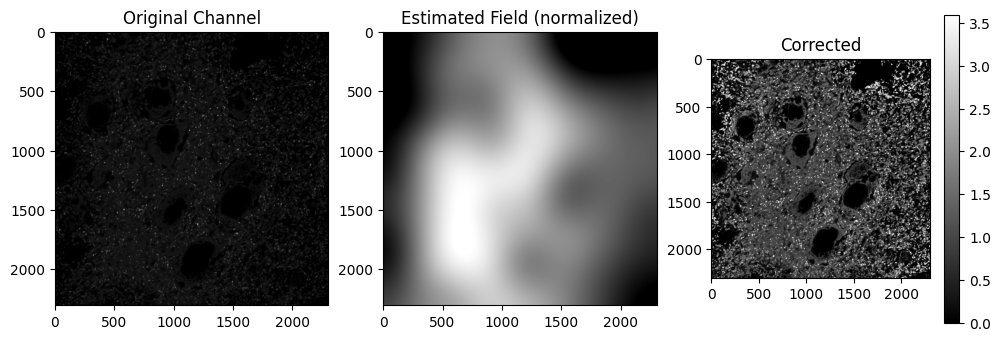

Channel 2: Skipped (range=0.00, mean=0.00)
Channel 3: Corrected (range=3.00, max_boost=3.00x)


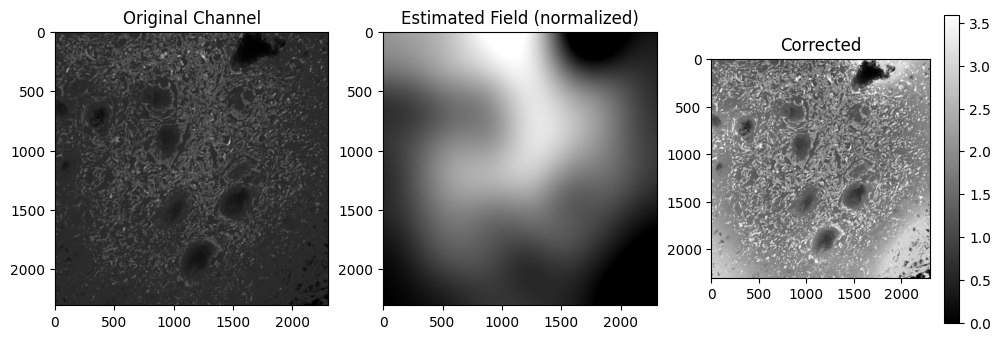

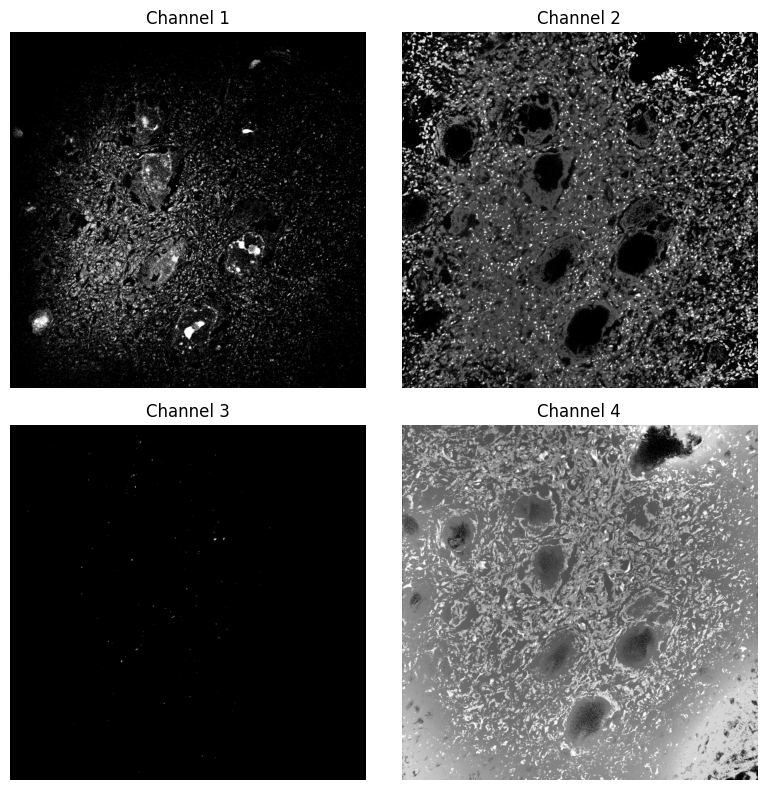

In [17]:
print(im_array.shape)
processed = PreprocessImage(im_array, plot=True)

# look at one of the tif files - verify if saved right
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()  # Flatten to easily iterate

# Plot each channel
for i in range(4):
    ax = axes[i]
    ax.imshow(processed[i, :, :,], cmap='gray')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()